In [64]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from scipy.stats import norm

np.set_printoptions(precision=15)
#set seed for reproducibility
set_seed = 1

rng = default_rng(1)
'''This script generates a continuous signal and discrete observations of the signal. 
The signal is a constant acceleration model. 
The observations are generated by adding noise to the true signal. 
The signal is generated for a time interval [0, 50] with a time step of 0.01. 
The observations are generated at discrete points with a time step of 1. 
The initial condition is drawn from the same distribution used for the Kalman filter and ensemble Kalman filter. 
'''
# The continuous signal is only used for plotting.
t0 = 0
tf = 60
t_dis = np.arange(t0, tf).T

m0 = np.array([2, 2]) #initial state of the system

sigma_v = 1
Q = sigma_v * np.eye(2) #process noise

sigma_n = 0.00001

F = np.array([[1,0.5],
              [0,1  ]]) #transition matrix

X_dis = np.zeros((2, len(t_dis)))
X_dis[:,0] = m0

H = np.array([[1,1]]) #observation matrix
Obs = np.zeros((len(t_dis)))
Obs[0] = H @ m0 

for i_time in range(0, len(t_dis)-1):
    X_dis[:, i_time+1] = F@X_dis[:, i_time] + rng.multivariate_normal([0,0],Q)

    Obs[i_time+1] = H @ X_dis[:,i_time+1] + rng.normal(0,sigma_n)

/var/folders/ls/yd1_54l95jq3d4wpt_5mrz980000gn/T/ipykernel_9458/2090566208.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Obs[0] = H @ m0
/var/folders/ls/yd1_54l95jq3d4wpt_5mrz980000gn/T/ipykernel_9458/2090566208.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Obs[i_time+1] = H @ X_dis[:,i_time+1] + rng.normal(0,sigma_n)


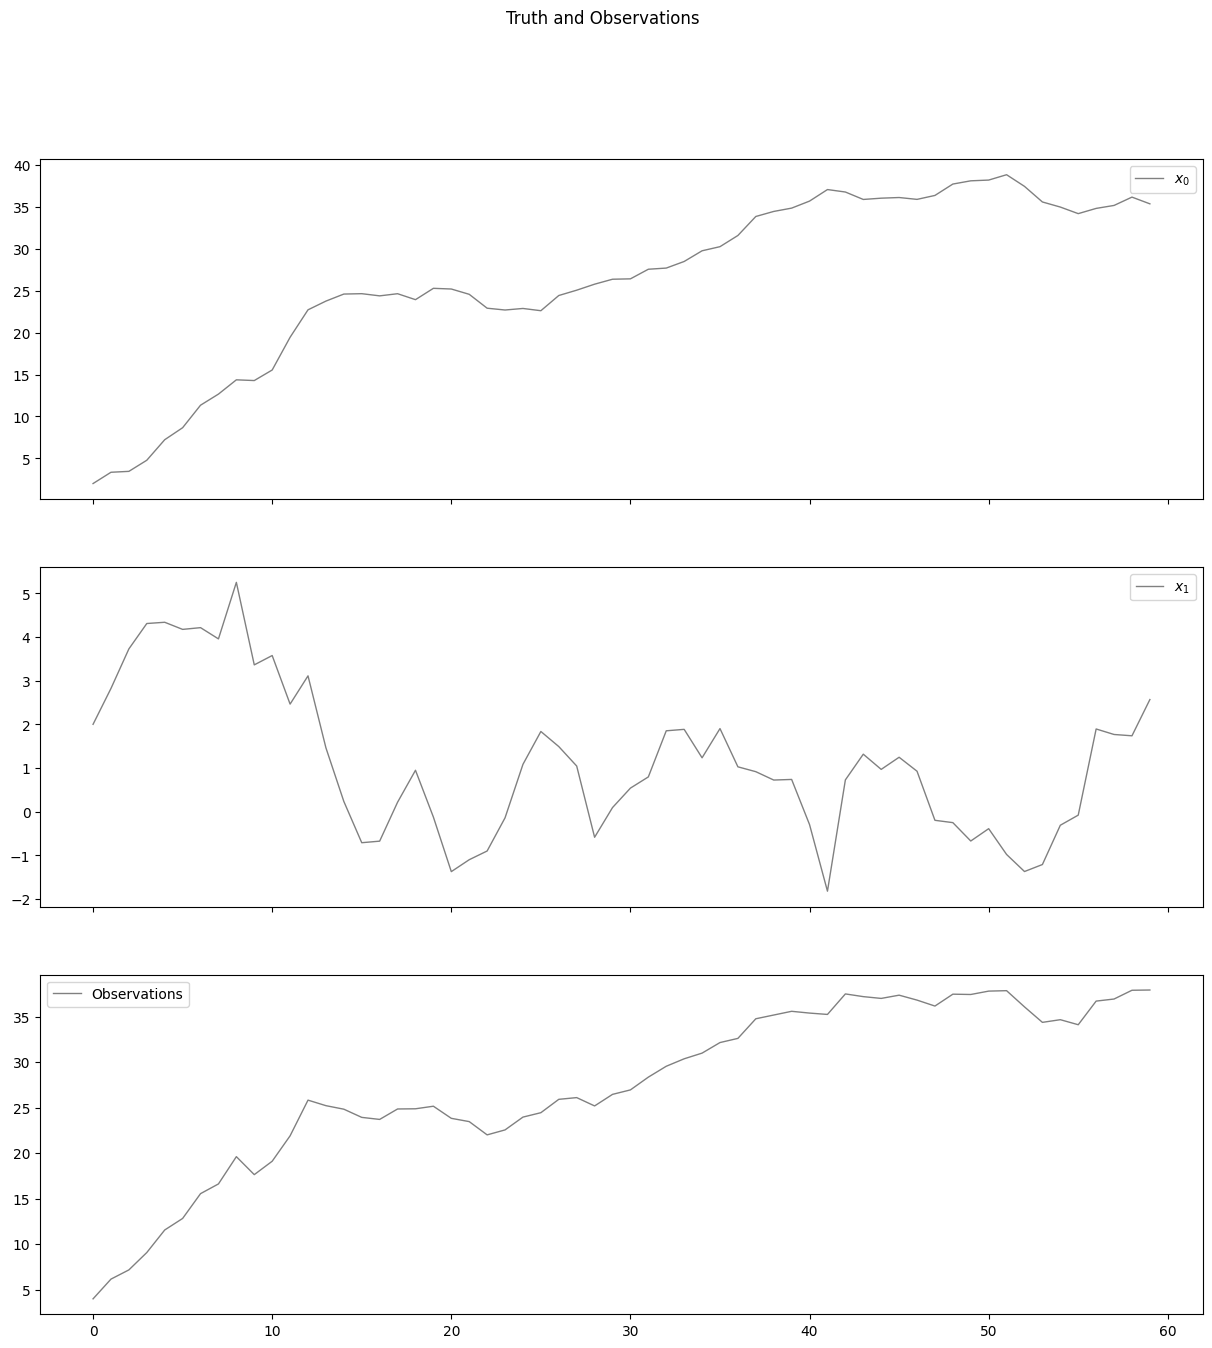

In [65]:
fig, axs = plt.subplots(3, 1, sharex=True,figsize=(15, 15))
fig.suptitle("Truth and Observations")
axs[0].plot(X_dis[0, :], color='gray', linewidth=1)
axs[1].plot(X_dis[1, :], color='gray', linewidth=1)

axs[2].plot(Obs, color='gray', linewidth=1)
# axs[0].scatter(t_dis, X_dis[0, :], s=10, color='k')
# axs[0].scatter(t_dis, Y, s=10, color='r')
axs[0].legend(['$x_0$'])
axs[1].legend(['$x_1$'])
axs[2].legend(['Observations'])

In [66]:
'''The Kalman filter is used to estimate the state of the system.'''
R0 = np.eye(2) #arbitrary initial covariance


m_prior = m0
R_prior = R0

K = R_prior@H.T@np.linalg.inv(H@R_prior@H.T + sigma_n)

# The mean is updated using the Joseph form of the Kalman filter.
m_post = np.zeros((2, len(t_dis)))
m_post[:, 0] = m_prior + K@(Obs[0] - H@m_prior)

# The covariance matrix is updated using the Joseph form of the Kalman filter.
R_post = np.zeros((2, 2, len(t_dis)))
R_post[:, :, 0] = R_prior - K@(H@R_prior@H.T + sigma_n)@K.T

# The Kalman filter is run for the rest of the time steps.
for i_time in range(0, len(t_dis)-1):
    m_prior = F@m_post[:, i_time] + rng.multivariate_normal([0,0],Q)
    R_prior = F@R_post[:, :, i_time].squeeze()@F.T + Q
    
    K = R_prior@H.T@np.linalg.inv(H@R_prior@H.T + sigma_n)

    m_post[:, i_time+1] = m_prior + K@(Obs[i_time+1] - H@m_prior)
    R_post[:, :, i_time+1] = R_prior - K@(H@R_prior@H.T + sigma_n)@K.T

#compute RMSE
#the following code computes the root mean square error between the true state and the estimated state
#then prints the RMSE for each state
rmse = np.sqrt(np.mean((X_dis - m_post)**2,axis = 1))
print(rmse)

[1.386444318407656 1.386443845247448]


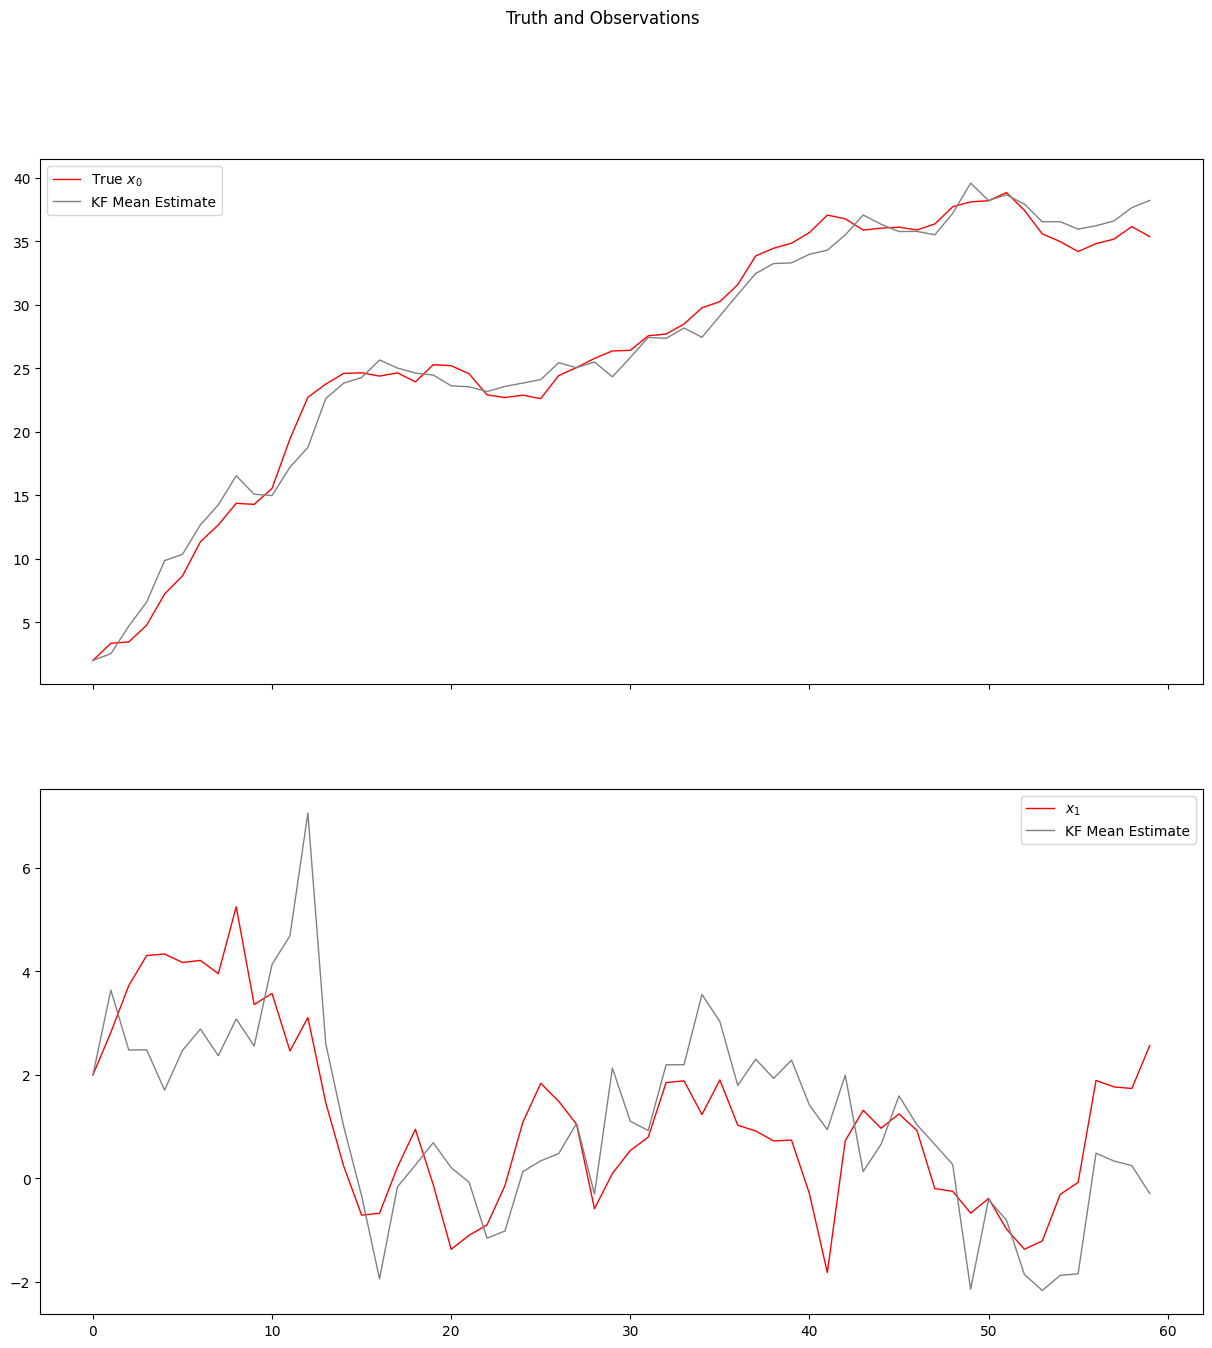

In [67]:
fig, axs = plt.subplots(2, 1, sharex=True,figsize=(15, 15))
fig.suptitle("Truth and Observations")
axs[0].plot(X_dis[0, :], color='red', linewidth=1)
axs[0].plot(m_post[0, :], color='gray', linewidth=1)

axs[1].plot(X_dis[1, :], color='red', linewidth=1)
axs[1].plot(m_post[1, :], color='gray', linewidth=1)


axs[0].legend(['True $x_0$','KF Mean Estimate'])
axs[1].legend(['$x_1$','KF Mean Estimate'])


In [68]:
'''Lin Domain Particle Filter'''

# #set seeds to ensure reproducibility
# rng = default_rng(set_seed)

num_particles = 200

particle_states = np.zeros((num_particles,2)) # particle array
particle_obs = np.zeros(num_particles)

m_post = np.zeros((2, len(t_dis))) # posterior means

weights = np.ones(num_particles) #weights associated with each particle

'''Setup each particle with an initial state as generated from the prior'''

particle_states = rng.multivariate_normal(m0,np.eye(2),num_particles).T
particle_obs = H @ particle_states


'''Set the weights for each particle in the initial swarm and normalize'''
weights = norm.pdf(Obs[0],loc=particle_obs,scale = sigma_n).squeeze()
weights += 10**-300
weights /= np.sum(weights)

'''Resample the weights'''

indices = np.arange(num_particles) #create a cumulative ndarray from 0 to particle_count

#The numpy resampling algorithm, see jupyter notebnook resampling.ipynb for more details
resampling_indices = rng.choice(a=indices, size=num_particles, replace=True, p=weights.squeeze())

particle_states_copy = np.copy(particle_states)

particle_states = particle_states_copy[:,resampling_indices]


m_post[:,0] = np.average(particle_states,axis = 1,weights = weights)


# The particle filter is run for the rest of the time steps.
for i_time in range(0, len(t_dis)-1):
    
    '''Simulate one time step for each particle and set the observations'''
    particle_states = F @ particle_states + rng.multivariate_normal([0,0],Q,num_particles).T
    particle_obs = H @ particle_states + rng.normal(0,sigma_n,num_particles)

    '''Set the weights for each particle in the swarm and normalize'''
    weights = norm.pdf(Obs[i_time],loc=particle_obs,scale = sigma_n).squeeze()
    weights += 10 **-300
    weights /= np.sum(weights)

    '''Resample'''
    resampling_indices = rng.choice(a=indices, size=num_particles, replace=True, p=weights)

    particle_states_copy = np.copy(particle_states)
    particle_states = particle_states_copy[:,resampling_indices]

    m_post[:,i_time+1] = np.average(particle_states,axis=1,weights = weights)

#compute RMSE
#the following code computes the root mean square error between the true state and the estimated state
#then prints the RMSE for each state
rmse = np.sqrt(np.mean((X_dis - m_post)**2,axis = 1))
print(rmse)

[25.308642415311045  2.15026882354411 ]


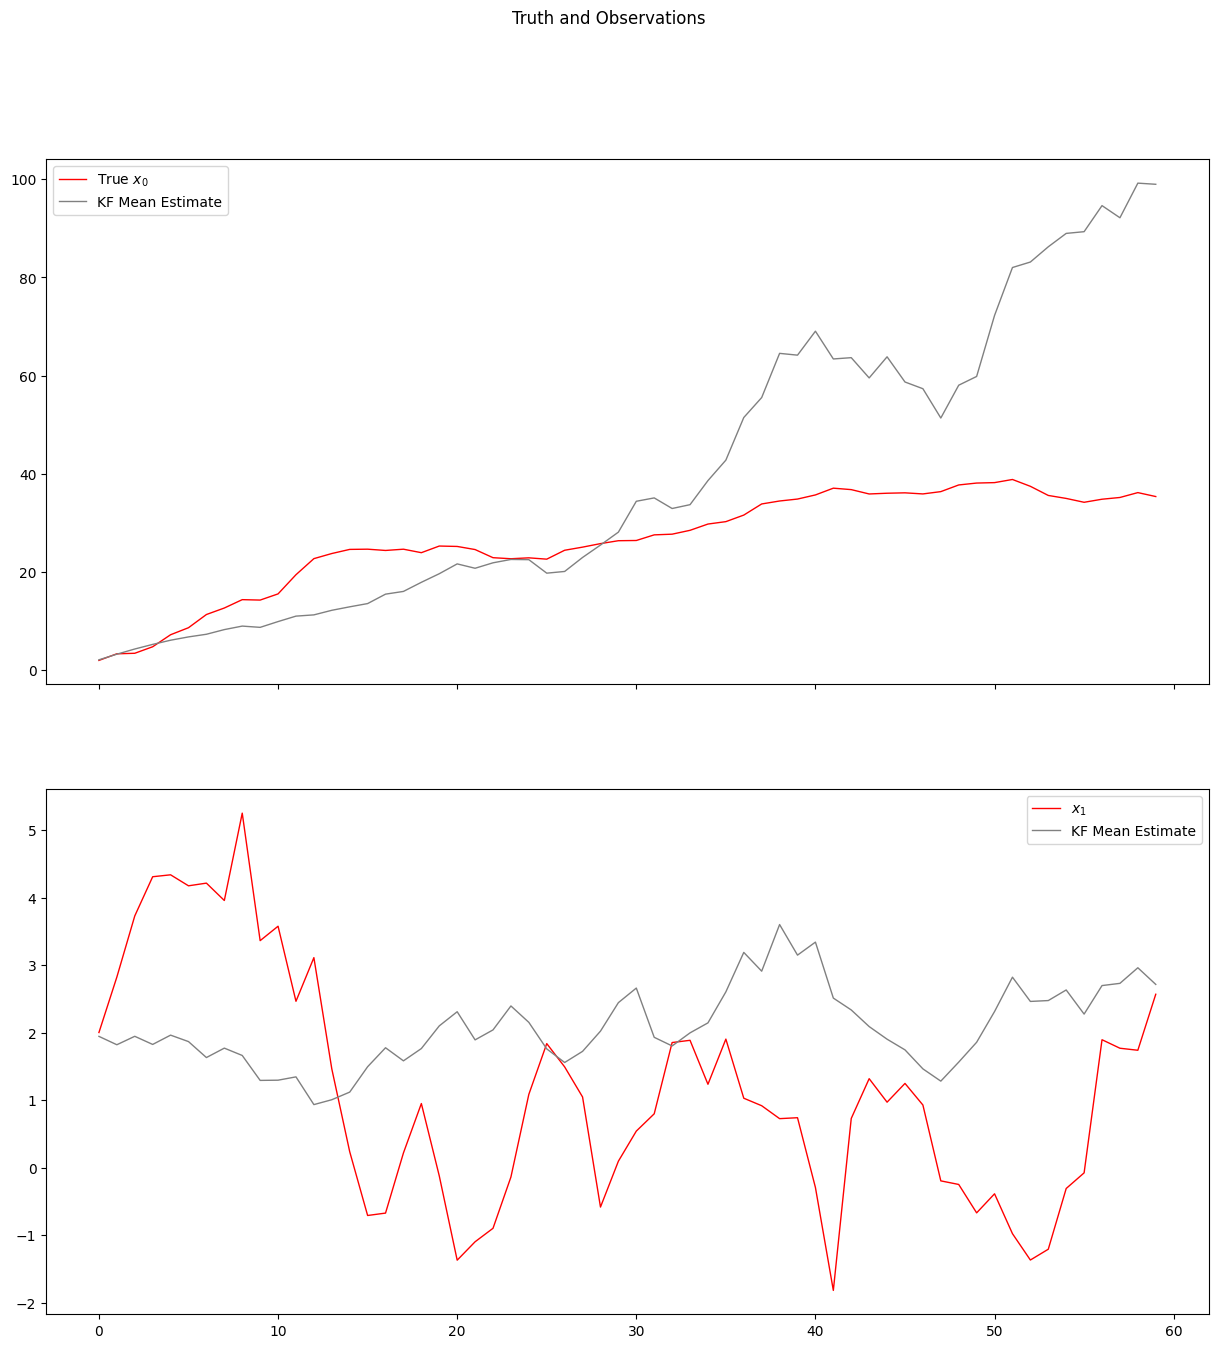

In [69]:
fig, axs = plt.subplots(2, 1, sharex=True,figsize=(15, 15))
fig.suptitle("Truth and Observations")
axs[0].plot(X_dis[0, :], color='red', linewidth=1)
axs[0].plot(m_post[0, :], color='gray', linewidth=1)

axs[1].plot(X_dis[1, :], color='red', linewidth=1)
axs[1].plot(m_post[1, :], color='gray', linewidth=1)


axs[0].legend(['True $x_0$','KF Mean Estimate'])
axs[1].legend(['$x_1$','KF Mean Estimate'])

In [70]:
def jacob(δ):
    """The jacobian logarithm, used in log likelihood normalization and resampling processes
    δ will be an array of values. 
    
    Args: 
        δ: An array of values to sum

    Returns: 
        The vector of partial sums of δ.          
    
    """
    n = len(δ)
    Δ = np.zeros(n)
    Δ[0] = δ[0]
    for i in range(1,n):
        Δ[i] = max(δ[i],Δ[i-1]) + np.log(1 + np.exp(-1*np.abs(δ[i] - Δ[i-1])))
    return(Δ)


def log_norm(log_weights): 
    '''normalizes the probability space using the jacobian logarithm as defined in jacob()'''
    norm = (jacob(log_weights)[-1])
    log_weights -= norm
    return log_weights

In [71]:
'''Log Domain Particle Filter'''
#set seeds to ensure reproducibility
# rng = default_rng(set_seed)

num_particles = 200

particle_states = np.zeros((num_particles,2)) # particle array
particle_obs = np.zeros(num_particles)

m_post = np.zeros((2, len(t_dis))) # posterior means

weights = np.ones(num_particles) #weights associated with each particle

'''Setup each particle with an initial state as generated from the prior'''

particle_states = rng.multivariate_normal(m0,np.eye(2),num_particles).T
particle_obs = H @ particle_states


'''Set the log-weights for each particle in the initial swarm and normalize'''
weights = norm.logpdf(Obs[0],loc=particle_obs,scale = sigma_n).squeeze()
weights = log_norm(weights)

'''Resample the weights

The algorithm proceeds as follows, 

        1. Generate the log-CDF via the jacobian logarithm. Currently uses the prior_weights, calls out to the jacob function in Utils which returns the whole vector of partial sums. 
            
        2. Resample using the standard systematic algorithm in the log domain. Note the value r is logged compared to the standard implementation, otherwise any systematic resampling literature
        describes the algorithm. 
'''
log_cdf = jacob(weights)
    

i = 0
resampling_indices = np.zeros(num_particles).astype(int)
u = rng.uniform(0,1/num_particles)
#The resampling algorithm in the log domain
for j in range(0,num_particles): 
    r = np.log(u + 1/num_particles * j)
    while r > log_cdf[i]: 
        i += 1
    resampling_indices[j] = i

#Resample the particles
particle_states_copy = np.copy(particle_states)
particle_states = particle_states_copy[:,resampling_indices]

m_post[:,0] = np.average(particle_states,axis = 1,weights = weights)



for i_time in range(0, len(t_dis)-1):
    
    '''Simulate one time step for each particle and set the observations'''
    particle_states = F @ particle_states + rng.multivariate_normal([0,0],Q,num_particles).T
    particle_obs = H @ particle_states + rng.normal(0,sigma_n,num_particles)

    '''Set the log-weights for each particle in the swarm and normalize'''
    weights = norm.logpdf(Obs[i_time],loc=particle_obs,scale = sigma_n).squeeze()
    weights = log_norm(weights)

    '''Resample in log domain'''
    log_cdf = jacob(weights)
    
    i = 0
    resampling_indices = np.zeros(num_particles)
    u = rng.uniform(0,1/num_particles)
    for j in range(0,num_particles): 
        r = np.log(u + 1/num_particles * j)
        while r > log_cdf[i]: 
            i += 1
        resampling_indices[j] = i

    resampling_indices=resampling_indices.astype(int)

    particle_states_copy = np.copy(particle_states)
    particle_states = particle_states_copy[:,resampling_indices]

    m_post[:,i_time+1] = np.average(particle_states,axis=1,weights = weights)

#compute RMSE
rmse = np.sqrt(np.mean((X_dis - m_post)**2,axis = 1))
print(rmse)

[1.395413587616116 1.58484164761226 ]


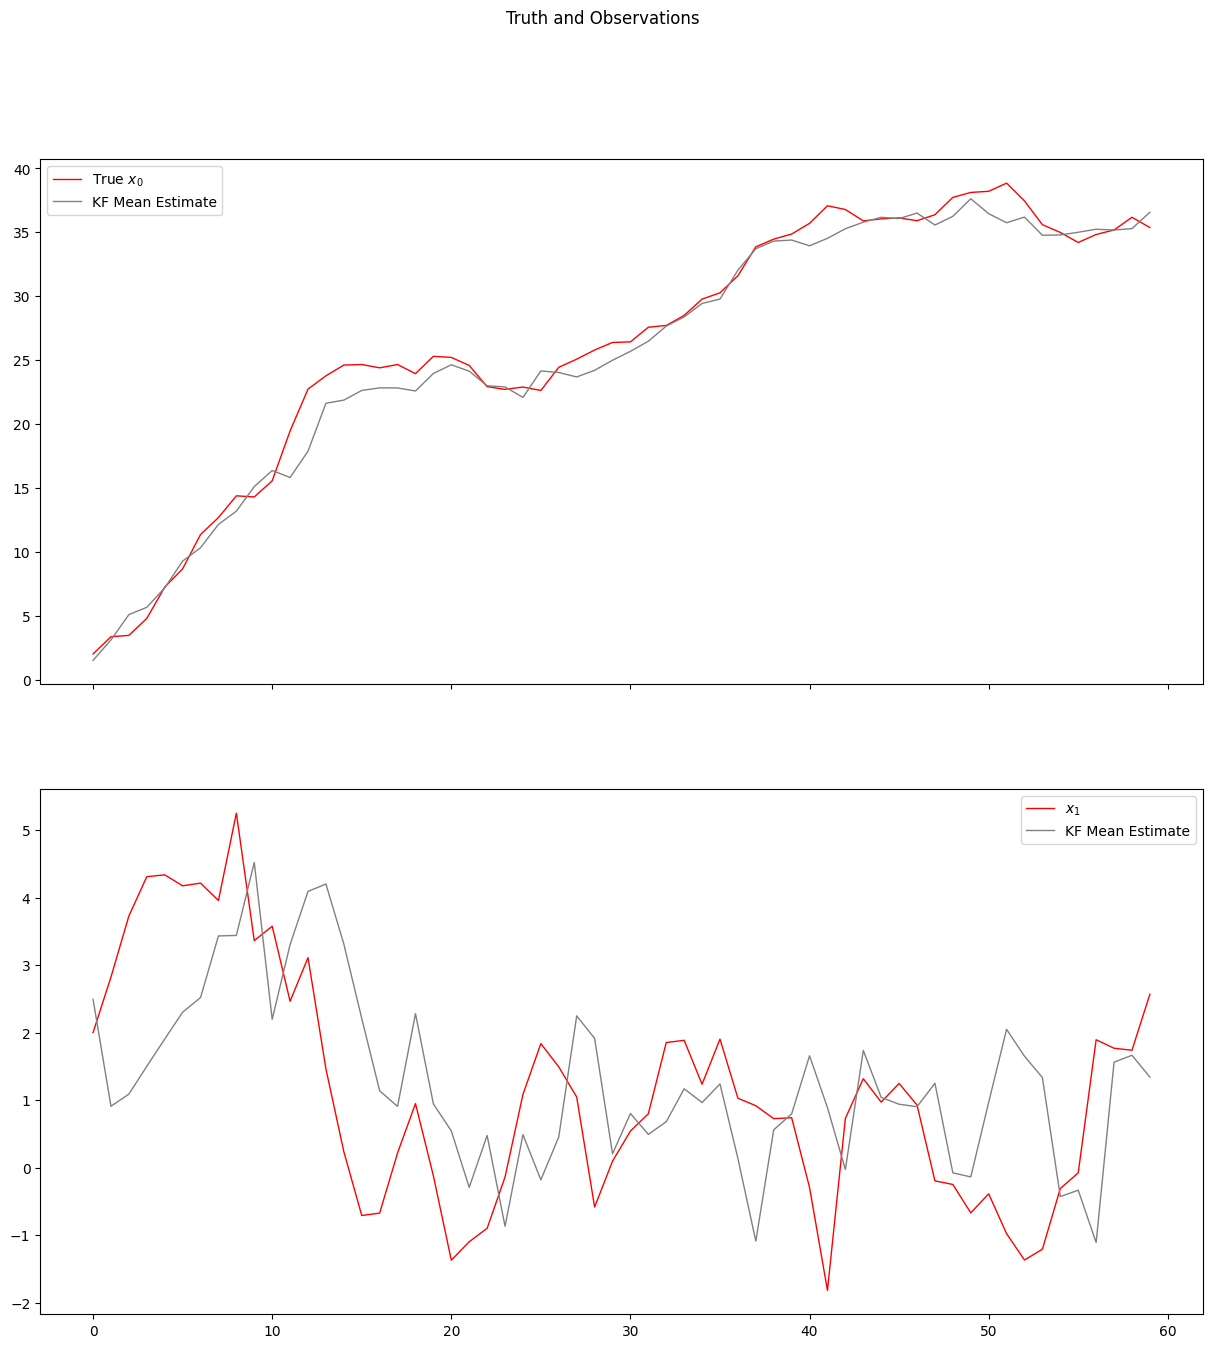

In [72]:
fig, axs = plt.subplots(2, 1, sharex=True,figsize=(15, 15))
fig.suptitle("Truth and Observations")
axs[0].plot(X_dis[0, :], color='red', linewidth=1)
axs[0].plot(m_post[0, :], color='gray', linewidth=1)

axs[1].plot(X_dis[1, :], color='red', linewidth=1)
axs[1].plot(m_post[1, :], color='gray', linewidth=1)


axs[0].legend(['True $x_0$','KF Mean Estimate'])
axs[1].legend(['$x_1$','KF Mean Estimate'])